**<font color = black size=6>实验十二：神经网络</font>**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import os  

本实验使用Pytorch框架搭建神经网络，其他类似的框架还有TensorFlow。若同学对TensorFlow框架更为熟悉，可使用TensorFlow完成本次实验

**<font color = blue size=4>第一部分:PyTorch介绍</font>**

这里介绍一小部分PyTorch常用的库和函数，更多需求可参阅[PyTorch官方教程](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)以及[PyTorch官方文档](https://pytorch.org/docs/stable/index.html)。

In [2]:
 print(torch.__version__) # 输出当前版本

2.1.0+cu121


**<font color = green size=3>1.Tensor</font>**

Tensor与NumPy中的ndarray很相似，但Tensor可以利用GPU来加速计算（本次实验中暂不涉及这部分内容）。

1.1. Tensor的创建

In [3]:
# 创建一个未初始化的Tensor
x = torch.empty(2, 3)
print(x)

# 从一个列表创建Tensor
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 创建一个随机Tensor
x = torch.rand([3, 4])
print(x)

# 创建一个全零Tensor
x = torch.zeros([2, 3])
print(x)

# 创建一个全一Tensor
x = torch.ones([2, 3])
print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[0.1305, 0.1829, 0.8020, 0.2264],
        [0.2422, 0.3832, 0.6763, 0.8930],
        [0.6743, 0.7726, 0.2031, 0.2531]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


1.2. Tensor的运算

In [4]:
# 加减法
x = torch.tensor([[1,2,3],
                  [4,5,6]])
y = torch.tensor([[6,5,4],
                  [3,2,1]])
print(x + y)
print(x - y)

# 对应位置相乘
print(x * y)
print(x.mul(y))

# 矩阵乘法
print(x.matmul(y.T))
print(x @ y.T)

# reshape
print(x.reshape(3, 2))

# 拼接
print(torch.cat([x,y], dim=0)) # 纵向拼接
print(torch.cat([x,y], dim=1)) # 横向拼接

tensor([[7, 7, 7],
        [7, 7, 7]])
tensor([[-5, -3, -1],
        [ 1,  3,  5]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[28, 10],
        [73, 28]])
tensor([[28, 10],
        [73, 28]])
tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [6, 5, 4],
        [3, 2, 1]])
tensor([[1, 2, 3, 6, 5, 4],
        [4, 5, 6, 3, 2, 1]])


1.3. Tensor与ndarray的相互转换

In [5]:
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 从Tensor转换到ndarray
y = x.numpy()
print(y)

# Tensor与ndarray是共享空间的
x[:]=0
print(y)

# 从ndarray到Tensor
z = torch.from_numpy(y)
print(z)

tensor([[1, 2, 3],
        [4, 5, 6]])
[[1 2 3]
 [4 5 6]]
[[0 0 0]
 [0 0 0]]
tensor([[0, 0, 0],
        [0, 0, 0]])


**<font color = green size=3>2.梯度计算</font>**

2.1 梯度计算

In [6]:
#定义变量
a = torch.tensor([[1., 2.]], requires_grad=True, device=torch.device('cuda:0'))
b = torch.tensor([[3.], [4.]], device=torch.device('cuda:0'))
c = torch.tensor(5., requires_grad=True, device=torch.device('cuda:0'))

#计算输出
z = a @ b + c

#自动计算梯度
z.backward()

#输出叶子节点的梯度
print(a.grad) #z对a的梯度
print(b.grad) #由于b默认requires_grad为false，因此无法计算梯度，输出为None
print(c.grad) #z对c的梯度

torch.cuda.device_count()

tensor([[3., 4.]], device='cuda:0')
None
tensor(1., device='cuda:0')


1

2.2 梯度清零

In [7]:
#支持多种运算求梯度，如torch.mean(),torch.sum()等
a = torch.ones(20, requires_grad=True)
z = torch.sum(torch.sigmoid(a))
z.backward()
print("梯度（a.grad）:", a.grad)


#多次求梯度时梯度会累加，可使用tensor.grad.zero_()进行手动清零
x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.backward()
print("求梯度后的结果（x.grad）:", x.grad)

z = x + 3
x.grad.zero_()  #可以将这句进行手动清零的代码注释掉后查看输出结果，来看到梯度清零的作用
z.backward()
print("求梯度后的结果（x.grad）:", x.grad)


梯度（a.grad）: tensor([0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966])
求梯度后的结果（x.grad）: tensor(4.)
求梯度后的结果（x.grad）: tensor(1.)


**<font color = green size=3>3. 神经网络</font>**

3.1 神经网络的构建

In [8]:
# 定义神经网络模型，继承自nn.Module
class Net(nn.Module):
    #输入层的维度为 input_dim
    #隐藏层的维度为 hidden_dim
    #输出层的维度为 output_dim
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        #激活函数relu，用于在全连接层之间加入非线性变换
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out1 = self.relu(out)
        out2 = self.fc2(out1)
        return out1,out2


# 创建神经网络模型实例并输出
net = Net(10,5,1)
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)


3.2 神经网络参数查询

In [9]:
# 该神经网络中可学习的参数可以通过net.parameters()访问
params = list(net.parameters())
print([params[i].size() for i in range(len(params))])  
print("Parameters:",params)

[torch.Size([5, 10]), torch.Size([5]), torch.Size([1, 5]), torch.Size([1])]
Parameters: [Parameter containing:
tensor([[-0.0126,  0.0156, -0.2912, -0.1532, -0.0579,  0.1386,  0.0008, -0.2679,
         -0.0102,  0.3106],
        [ 0.1346,  0.0698, -0.0770,  0.0839,  0.1571, -0.3155, -0.0081,  0.2816,
          0.1080,  0.2747],
        [-0.2047,  0.0452,  0.2324,  0.2908, -0.2687, -0.0810, -0.0862,  0.1954,
          0.1506, -0.1226],
        [-0.0087,  0.0577, -0.0307, -0.0606, -0.1524, -0.1479,  0.0797, -0.0962,
         -0.1303,  0.0987],
        [-0.1390, -0.2948, -0.1542, -0.2270,  0.1621, -0.2716,  0.1992, -0.2311,
         -0.2114,  0.2927]], requires_grad=True), Parameter containing:
tensor([-0.0895, -0.1292,  0.3037, -0.1785,  0.1963], requires_grad=True), Parameter containing:
tensor([[ 0.0948, -0.4045, -0.1658, -0.2330, -0.1880]], requires_grad=True), Parameter containing:
tensor([0.3853], requires_grad=True)]


3.3 神经网络前向传播

In [10]:
net.eval()
#输入维度为10，生成数据
input=torch.ones([1,10])
input=input.float()

# 进行一次forward()前向传播
output1, output2  = net(input) 

# 前向传播并输出每一层的输出值
print("Output of first layer:", output1)
print("Output of second layer:", output2)

Output of first layer: tensor([[0.0000, 0.5798, 0.4548, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
Output of second layer: tensor([[0.0754]], grad_fn=<AddmmBackward0>)


3.4 神经网络反向传播

In [11]:
loss_fn = nn.MSELoss()
target = torch.randn(1, 1)
loss = loss_fn(output2, target)

# 反向传播并输出每一层的梯度
net.zero_grad()
loss.backward()

print("Gradients of first layer:")
print(net.fc1.weight.grad)
print(net.fc1.bias.grad)

print("Gradients of second layer:")
print(net.fc2.weight.grad)
print(net.fc2.bias.grad)

Gradients of first layer:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.3301, -0.3301, -0.3301, -0.3301, -0.3301, -0.3301, -0.3301, -0.3301,
         -0.3301, -0.3301],
        [-0.1353, -0.1353, -0.1353, -0.1353, -0.1353, -0.1353, -0.1353, -0.1353,
         -0.1353, -0.1353],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]])
tensor([ 0.0000, -0.3301, -0.1353,  0.0000,  0.0000])
Gradients of second layer:
tensor([[0.0000, 0.4732, 0.3711, 0.0000, 0.0000]])
tensor([0.8161])


3.5 训练神经网络的全过程例子

In [12]:
# 创建一个简单的线性回归模型
model = nn.Linear(1, 1)
print(list(model.parameters()))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch=10

#生成数据
inputs = torch.tensor([[1.0], [2.0], [3.0]])
labels = torch.tensor([[2.0], [4.0], [6.0]])

# 模拟训练过程
for epoch in range(Epoch):
    # 模拟输入数据和标签
    
    # 前向传播
    outputs = model(inputs)

    # 计算损失
    loss = criterion(outputs, labels)
    
    #梯度清零
    optimizer.zero_grad()
    
    
    # 反向传播
    loss.backward()

    
    # 更新参数
    optimizer.step()

    # 打印梯度值
    print('Epoch [{}/{}], Loss: {}'.format(epoch+1,Epoch, loss),'. Gradient: {}'.format(model.weight.grad))
    #print('Gradient: {}'.format(model.weight.grad))


[Parameter containing:
tensor([[-0.3593]], requires_grad=True), Parameter containing:
tensor([-0.0506], requires_grad=True)]
Epoch [1/10], Loss: 26.455734252929688 . Gradient: tensor([[-22.2224]])
Epoch [2/10], Loss: 20.93194007873535 . Gradient: tensor([[-19.7667]])
Epoch [3/10], Loss: 16.565582275390625 . Gradient: tensor([[-17.5835]])
Epoch [4/10], Loss: 13.114112854003906 . Gradient: tensor([[-15.6424]])
Epoch [5/10], Loss: 10.38581657409668 . Gradient: tensor([[-13.9166]])
Epoch [6/10], Loss: 8.229147911071777 . Gradient: tensor([[-12.3823]])
Epoch [7/10], Loss: 6.524322509765625 . Gradient: tensor([[-11.0181]])
Epoch [8/10], Loss: 5.17665433883667 . Gradient: tensor([[-9.8052]])
Epoch [9/10], Loss: 4.111300945281982 . Gradient: tensor([[-8.7269]])
Epoch [10/10], Loss: 3.2691032886505127 . Gradient: tensor([[-7.7681]])


3.5 神经网络参数更新

1) 用梯度下降法(手动)更新net中的参数

In [13]:
#for f in net.parameters():
    #f.data.sub_(f.grad.data * learning_rate)

2) 用PyTorch的优化器来更新net中的参数

In [14]:
#选择优化器
#optimizer = optim.SGD(net.parameters(), lr=0.01)

# 建立循环:
#optimizer.zero_grad()             # 梯度清零
#output = net(input)               # 前向传播
#loss = criterion(output, target)  # 计算误差
#loss.backward()                   # 后向传播
#optimizer.step()                  # 参数更新

**<font color = blue size=4>第二部分:实验内容</font>**

[Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)是一个关于红酒品质的数据集，总共有1599个样本，每个样本包含11个(都是连续的)特征以及1个标签，每个标签的取值是连续的。本次实验已经按照8：2的比例划分成了训练数据集'wine_train.csv'以及测试数据集'wine_test.csv'，且每个数据集都已经做了归一化处理。

<span style="color:purple">1) 读入训练数据集'wine_train.csv'与测试数据集'wine_test.csv'。</span>

In [32]:
#your code here
# 读取训练数据集
train_frame = pd.read_csv('wine_train.csv')
# 读取测试数据集
test_frame = pd.read_csv('wine_test.csv')

# 将数据转换为张量
X_train = torch.tensor(train_frame.drop('quality', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(train_frame['quality'].values, dtype=torch.float32)

X_test = torch.tensor(test_frame.drop('quality', axis=1).values, dtype=torch.float32)
y_test = torch.tensor(test_frame['quality'].values, dtype=torch.float32)

X_train

tensor([[0.3540, 0.2397, 0.2700,  ..., 0.3465, 0.2814, 0.4308],
        [0.1770, 0.5034, 0.0200,  ..., 0.6299, 0.1617, 0.4000],
        [0.5221, 0.0822, 0.4700,  ..., 0.3228, 0.3413, 0.4000],
        ...,
        [0.2301, 0.3082, 0.0500,  ..., 0.5039, 0.1617, 0.2923],
        [0.2832, 0.3082, 0.3100,  ..., 0.4331, 0.1198, 0.1385],
        [0.1947, 0.3836, 0.2100,  ..., 0.5039, 0.1617, 0.2923]])

<span style="color:purple">2) 利用线性层和激活函数搭建一个神经网络，要求输入和输出维度与数据集维度一致，而神经网络深度、隐藏层大小、激活函数种类等超参数自行调整。</span>

In [33]:
#your code here
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = 11
hidden_dim = 50
output_dim = 1

net = Net(input_dim, hidden_dim, output_dim)

<span style="color:purple">3) 用PyTorch的优化器(随机梯度下降)来进行模型参数更新，记下每轮迭代中的训练损失和测试损失。</span>

In [34]:
#your code here
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 使用随机梯度下降优化器，学习率为0.01

# 记录每轮迭代中的训练损失和测试损失
train_losses = []
test_losses = []

# 设置训练轮数
epochs = 50 

# 训练循环
for epoch in range(epochs):
    # 设置模型为训练模式
    net.train()

    # 训练数据集
    optimizer.zero_grad()  # 梯度清零
    outputs = net(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数
    train_losses.append(loss.item())

    # 测试
    net.eval()
    with torch.no_grad():
        test_outputs = net(X_test)
        test_loss = criterion(test_outputs, y_test.view(-1, 1))
        test_losses.append(test_loss.item())

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch 1/50, Train Loss: 0.3528, Test Loss: 0.3152
Epoch 2/50, Train Loss: 0.3158, Test Loss: 0.2823
Epoch 3/50, Train Loss: 0.2828, Test Loss: 0.2530
Epoch 4/50, Train Loss: 0.2535, Test Loss: 0.2269
Epoch 5/50, Train Loss: 0.2275, Test Loss: 0.2038
Epoch 6/50, Train Loss: 0.2043, Test Loss: 0.1832
Epoch 7/50, Train Loss: 0.1837, Test Loss: 0.1649
Epoch 8/50, Train Loss: 0.1654, Test Loss: 0.1487
Epoch 9/50, Train Loss: 0.1491, Test Loss: 0.1343
Epoch 10/50, Train Loss: 0.1347, Test Loss: 0.1215
Epoch 11/50, Train Loss: 0.1218, Test Loss: 0.1102
Epoch 12/50, Train Loss: 0.1105, Test Loss: 0.1002
Epoch 13/50, Train Loss: 0.1004, Test Loss: 0.0913
Epoch 14/50, Train Loss: 0.0915, Test Loss: 0.0835
Epoch 15/50, Train Loss: 0.0836, Test Loss: 0.0766
Epoch 16/50, Train Loss: 0.0767, Test Loss: 0.0704
Epoch 17/50, Train Loss: 0.0705, Test Loss: 0.0650
Epoch 18/50, Train Loss: 0.0650, Test Loss: 0.0603
Epoch 19/50, Train Loss: 0.0602, Test Loss: 0.0561
Epoch 20/50, Train Loss: 0.0560, Test Lo

<span style="color:purple">4) 画出训练损失和测试损失关于迭代轮数的折线图。</span>

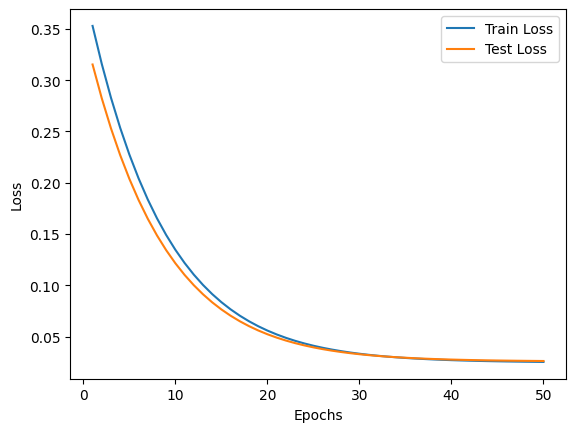

In [35]:
#your code here
# 画出训练损失和测试损失的折线图
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可

二、本次实验分为两周完成，实验报告提交截止日期: 12月15号14:20  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  

实验十二(神经网络)的实验报告上交地址: https://send2me.cn/Wk9FsyYO/SKCBsWeFtvwQsg

三、课堂课件获取地址:https://www.jianguoyun.com/p/DWHYtsEQp5WhChjwtKoFIAA
实验内容获取地址:https://www.jianguoyun.com/p/DbNY_SIQp5WhChjvtKoFIAA